## 1. 数据进行预处理
将数据读入内存, 并封装在Article类中.

In [86]:
class Article:
    def __init__(self, str):
        self.authors = []
        lines = str.split('\n')
        for line in lines:
            if line is '' or line is None or line == "":
                continue
            key, value = line.split('\t', 1)
            if key == 'author':
                self.authors.append(value)
            elif key == 'title':
                self.title = value
            elif key == 'year':
                self.year = value
            elif key == 'Conference':
                self.conference = value
    
    def display(self):
        str = ' '.join(self.authors) + ':' + self.title + ',' + self.conference
        print(str)
    
    
def parse_article(filename):
    fin = open(filename)
    content = fin.read()
    blocks = content.split('#########')
    articles = []
    for block in blocks:
        if block is '' or block is None or block == "":
            continue
        art = Article(block)
        # art.display()
        articles.append(art)
    return articles

def printTable(myDict, colList=None):
   """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
   if not colList: colList = list(myDict[0].keys() if myDict else [])
   myList = [colList] # 1st row = header
   for item in myDict: myList.append([str(item[col] or '') for col in colList])
   colSize = [max(map(len,col)) for col in zip(*myList)]
   formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
   myList.insert(1, ['-' * i for i in colSize]) # Seperating line
   for item in myList: print(formatStr.format(*item))
        
articles = parse_article('data/FilteredDBLP.txt')

## 2. 活跃作者挖掘
根据时间信息，看看哪些人依然活跃，哪些人不再活跃。

我们将作者散列在二维图上, 随着作者出现次数的增加, 散列点越来越大.
- 如图2.1所示, 越活跃的作者(出现次数越多), 散列点越大;
- 如图2.2所示, 我们将活跃的作者(至少出现5次以上)依据其出现的年份连成一条活跃年份图.

Sn.      Author Name                         Years     
-----    -------------                       --------- 
0        Susan Zhang                         ['2014']  
1        Tianwei Xing                        ['2017']  
2        Alvaro A. Cárdenas                  ['2007']  
3        Mrinal Kalakrishnan                 ['2008']  
4        Matthew T. Harrison                 ['2013']  
5        Assaf Zeevi                         ['2017', '2010']
6        Muthukumaran Chandrasekaran         ['2017', '2016', '2011', '2016']
7        Safa Yahi                           ['2008', '2007']
8        Umberto Straccia                    ['2010', '2011']
9        Freek Stulp                         ['2008', '2017']
10       Janani Kalyanam                     ['2015']  
11       Ping Wang                           ['2016', '2010', '2017']
12       Charu Chauhan                       ['2016']  
13       Thomas Schmitz                      ['2015', '2015', '2016']
14       Rui Cao              

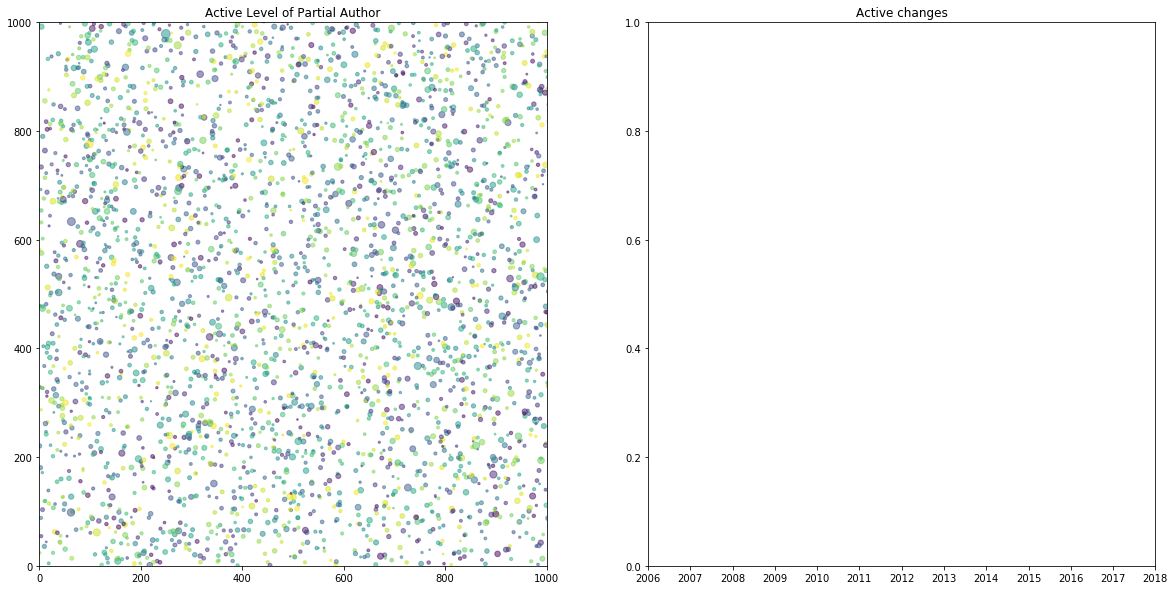

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

# Statistics the number of author occurences and years
author_years = dict()
for article in articles:
    for author in article.authors:
        if author in author_years:
            author_years[author].append(article.year)
        else:
            author_years[author] = [article.year]
            
print("{:<8} {:<35} {:<10}".format('Sn.','Author Name','Years'))
print("{:<8} {:<35} {:<10}".format('-----','-------------','---------'))
for idx, kv in enumerate(author_years.items()):
    key, value = kv
    print("{:<8} {:<35} {:<10}".format(idx, key, str(value)))
    if idx > 100:
        break

# print(author_years)
#for row in zip(*([key] + (value) for key, value in sorted(author_years.items()))):
#    print(*row)

# 1. plot the ative level
N = len(articles)
x = np.random.rand(N) * 3000
y = np.random.rand(N) * 3000
colors = np.random.rand(N)
area = np.pi * (15 * np.array([len(years)/100.0 for years in author_years.keys()]))**2  # 0 to 15 point radii

fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(121)
# ax1.xlim(0, 500)
ax1.set_xlim([0, 1000])
ax1.set_ylim([0, 1000])
ax1.scatter(x, y, s=area, c=colors, alpha=0.5)
ax1.set_title('Active Level of Partial Author')
ax1.legend(numpoints=1, loc='upper left')


# 2. plot the ative changes
ax2 = fig1.add_subplot(122)
ax2.set_title('Active changes')
ax2.set_xlim([2006, 2018])
ax2.set_xticks([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])



plt.show()

## 3. 频繁项挖掘
经常性在一起合作的 学者，将之称为‘团队’, 根据研究者合作发表论文次数为根据 进行频繁模式挖掘，找出三个人以上的‘团队’.

- 找出支持度support>=5的所有学者

In [74]:
from pymining import itemmining
# transactions = (('a', 'b', 'c'), ('b'), ('a'), ('a', 'c', 'd'), ('b', 'c'), ('b', 'c'))
# relim_input = itemmining.get_relim_input(transactions)
# report = itemmining.relim(relim_input, min_support=2)

authors = [article.authors for article in articles]
relim_input = itemmining.get_relim_input(authors)
report = itemmining.relim(relim_input, min_support=5)

- 找出合作者个数大于3的所有合作团队

In [96]:
counter = 0
for r in report:
    if len(r) >= 3:
        counter += 1
       # print(r)
print(counter)

268


## 4. 主题挖掘
先定出主题词， 然后根据每个‘团队’发表的论文的情况，提炼出这个团队最常涉猎 的主题。

- 根据Latent Dirichlet allocation(LDA)主题模型训练出所有的模型:

In [87]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

# compile sample documents into a list
titles = [article.title for article in articles]
doc_set = []
for title in titles:
    doc_set.append(title)

# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=20)

- 使用***作者<--->标题<--->主题***这个映射将作者经常所涉猎的主题进行关联:

In [105]:
topics = ldamodel.get_topics()
# print(ldamodel.show_topic(19, topn=3))
doc2topics = ldamodel.get_document_topics(corpus)
# print(len(doc2topics))
# print(doc2topics[0])
# print(doc2topics[1])
# len(doc2topics)

for idx, article in enumerate(articles[:10]):
    max_pro_topic = 0
    max_pro = 0.0
    # Find the topic_id with maximum probability
    for topic_id, pro in doc2topics[idx]:
        if pro > max_pro:
            max_pro = pro
            max_pro_topic = topic_id
    # print(max_pro_topic)
    topic_terms = [topic_pro[0] for topic_pro in ldamodel.show_topic(max_pro_topic, topn=3)]
    str = ', '.join(article.authors) + "--->" + ', '.join(topic_terms)
    print(str)

Miroslaw Truszczynski, Stefan Woltran--->logic, program, probabilist
Guibing Guo, Jie Zhang, Neil Yorke-Smith--->inform, improv, retriev
Xinwang Liu, Yong Dou, Jianping Yin, Lei Wang 0001, En Zhu--->graph, match, cluster
Mickey Brautbar, Michael J. Kearns, Umar Syed--->factor, matrix, decis
Shirin Sohrabi, Anton V. Riabov, Octavian Udrea--->effici, high, search
Maximilian Nickel, Lorenzo Rosasco, Tomaso A. Poggio--->graph, match, cluster
Kyle Lund, Sam Dietrich, Scott Chow, James C. Boerkoel--->search, tempor, visual
Leandro Soriano Marcolino, Boian Kolev, Samori Price, Sreerag Palangat Veetil, David Jason Gerber, Josef Musil, Milind Tambe--->optim, larg, scale
Russell Bent, Alan Berscheid, G. Loren Toole--->social, person, joint
Vibhav Gogate, Rina Dechter--->robust, estim, hierarch


## 5. 团队和主题多是会随着时间而动态变化
根据自己所定的时 间段(五年，三年，两年或是一年)描述团队的构成状况以及其 研究主题的变化情况。